In [1]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Model
from images import get_images_eval, create_batch, images_train, images_valid, BATCH_SIZE
from tensorflow.keras import layers, models, optimizers
import numpy as np

images_eval = get_images_eval()
input_shape = images_eval.shape[1:]
# input = layers.Input(input_shape)
resnet_base = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")
decoder = models.Sequential(name='decoder')
decoder.add(layers.Flatten())
decoder.add(layers.Dense(512, activation='relu'))
decoder.add(layers.Dense(1024, activation='relu'))
decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))
resnet_embedding = Model(inputs=resnet_base.inputs, outputs=decoder(resnet_base.output), name='ResNet50')
resnet_embedding.summary(), #resnet_embedding.layers #, decoder.summary()
# tf.keras.utils.plot_model(resnet_embedding, to_file="model.png", show_shapes=True, layer_range=["input_7", "conv2_block1_out"])
# from tensorflow.keras import optimizers

# tf.keras.utils.plot_model(resnet_embedding, to_file="model.png", show_shapes=True)
# predict_and_print(resnet_embedding, images_eval, "images_eval_resnet")

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


c:\Users\Tautvydas\Documents\magistras\master_capsnet\venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0-rc2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

(None,)

In [2]:
input_a = layers.Input(name="anchor", shape=images_eval.shape[1:])
input_p = layers.Input(name="positive", shape=images_eval.shape[1:])
input_n = layers.Input(name="negative", shape=images_eval.shape[1:])

embedding_a = resnet_embedding(input_a)
embedding_p = resnet_embedding(input_p)
embedding_n = resnet_embedding(input_n)

output = layers.concatenate([embedding_a, embedding_p, embedding_n], axis=1)
# print(output)

siamese_net = models.Model([input_a, input_p, input_n], output)
siamese_net.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
ResNet50 (Functional)           (None, 32, 32, 3)    28310912    anchor[0][0]                     
                                                                 positive[0][0]               

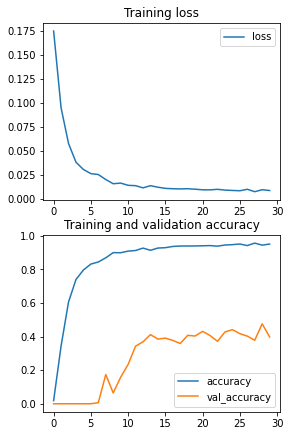

In [3]:
from metrics import accuracy, triplet_loss, get_callbacks
from utils.utils import plot_log

emb_size = 32
def data_generator(images):
    while True:
        x = create_batch(images, (32, 32, 3))
        y = np.zeros((100, 3*emb_size))
        yield [x[0], x[1], x[2]], y

# data_generator().send(None)[0][0].shape

lr = 0.00006
optimiser_obj = optimizers.Adam(learning_rate=lr)
siamese_net.compile(loss=triplet_loss, optimizer=optimiser_obj, metrics=[accuracy])

resnet_triplet_net_dir = './result/resnet_imagenet/resnet_triplets-norm'
net_callbacks = get_callbacks(resnet_triplet_net_dir, lr, 0.9, 'val_accuracy')
weights_file = resnet_triplet_net_dir + '/trained_model_05-17-30e.h5'
run_fit = False
if(run_fit):
    siamese_net.fit(
        data_generator(images_train),
        steps_per_epoch=int(len(images_train)/BATCH_SIZE), 
        epochs=30, 
        validation_data=data_generator(images_valid),
        validation_steps=int(len(images_valid)/BATCH_SIZE),
        callbacks=[net_callbacks])
    siamese_net.save_weights(weights_file)
    print('Trained model saved to \'%s\'' % weights_file)
else:
    siamese_net.load_weights(weights_file)

plot_log(resnet_triplet_net_dir + '/log.csv', show=True)

In [4]:
from images import get_images_eval, predict_and_print, create_batch, images_train, images_valid, images_test, preprocess_image_with_angle

shape = images_eval.shape[1:]
x_a = np.zeros((BATCH_SIZE*10, *shape))  # * - expands tuple
x_p = np.zeros((BATCH_SIZE*10, *shape))  # * - expands tuple
x_n = np.zeros((BATCH_SIZE*10, *shape))  # * - expands tuple
for i in range(10):
    for j in range(10):
        for angle in range(10):
            image_a = preprocess_image_with_angle(
                images_test[i*3], angle, 10)
            image_p = preprocess_image_with_angle(
                images_test[i*3+1], 0, 10)
            image_n = preprocess_image_with_angle(
                images_test[j*3+2], 0, 10)
            x_a[i*100 + j*10 + angle] = image_a
            x_p[i*100 + j*10 + angle] = image_p
            x_n[i*100 + j*10 + angle] = image_n
images_test_eval = np.array([x_a, x_p, x_n])
images_test_eval.shape, len(images_test)

((3, 1000, 32, 32, 3), 30)

(1000, 96, 32, 3) (1000, 96, 32, 3)
Reconstructed images are saved to ./result/resnet_imagenet/resnet_triplets-norm/triplet_recon.png
------------------------------End: test------------------------------


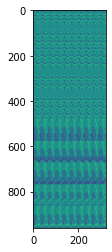

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
from utils.utils import combine_images
file_name = "triplet_recon"
x_recon = siamese_net.predict([x_a, x_p, x_n], batch_size=100)
images_test_eval_x = np.concatenate(images_test_eval, axis=1)
print(x_recon.shape, images_test_eval_x.shape)
# img = combine_images(np.concatenate([x_recon[:3], x_recon[10:13]]))
img = combine_images(np.concatenate([x_recon[:50], images_test_eval_x[:50]]))
def print_combined_embeddings(image, save_dir, file_name):
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save(
            save_dir + "/" + file_name + ".png")
    print('Reconstructed images are saved to %s/%s.png' %
            (save_dir, file_name))
    print('-' * 30 + 'End: test' + '-' * 30)
    plt.imshow(plt.imread(save_dir + "/" + file_name + ".png"))
    plt.show()
print_combined_embeddings(img, resnet_triplet_net_dir, file_name)

In [22]:
int(11%100/10)

1

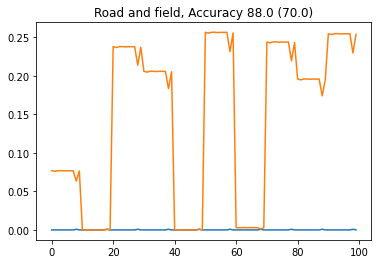

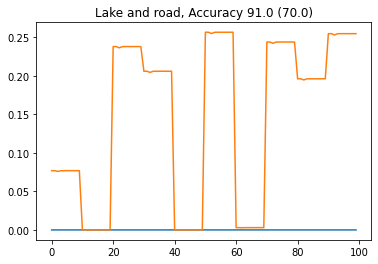

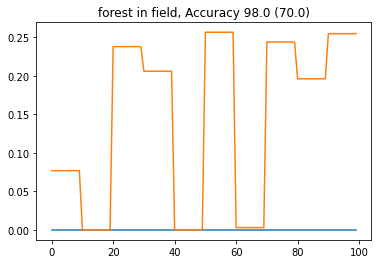

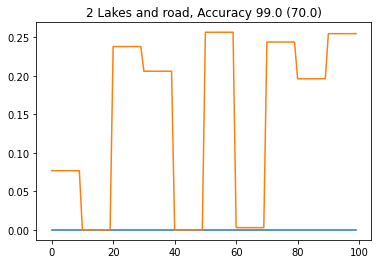

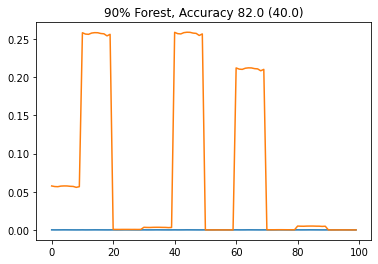

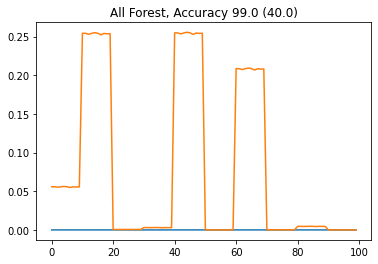

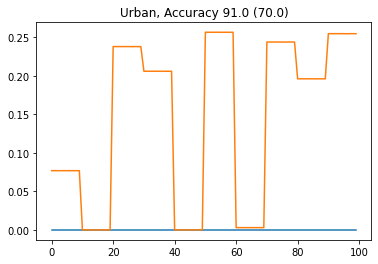

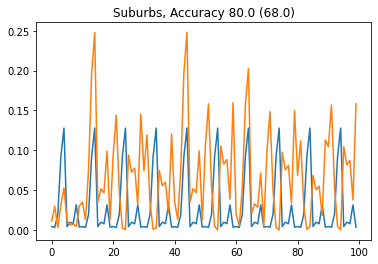

0.864 0.608


In [28]:

test_data_list = [(range(0, 100), 'Road and field'),
                  (range(100, 200), 'Lake and road'),
                  (range(200, 300), 'forest in field'),
                  (range(300, 400), '2 Lakes and road'),
                  (range(400, 500), 'Road and forest'),
                  (range(500, 600), 'Forest with shape'),
                  (range(600, 700), '90% Forest'),
                  (range(700, 800), 'All Forest'),
                  (range(800, 900), 'Urban'),
                  (range(900, 1000), 'Suburbs')]


def show_graph(_range, title, x_recon, emb_size, path):
    margin = 0.01
    tp = 0
    tp_m = 0  # with small margin
    fp_m = 0  # with small margin
    fp = 0
    xaxis = []
    yaxis = []
    for i in _range:
        # ds_i = int(i%100/10)
        embedding_img_a = x_recon[i, :emb_size]
        embedding_img_p = x_recon[i, emb_size:2*emb_size]
        embedding_img_n = x_recon[i, 2*emb_size:]
        # embedding_img_a.shape, embedding_img_p.shape, embedding_img_n.shape
        p = np.mean(np.square(embedding_img_a - embedding_img_p))
        n = np.mean(np.square(embedding_img_a - embedding_img_n))
        # print(p, n)
        pda = np.nansum(p)
        pda_m = pda + margin
        nda = np.nansum(n)
        # print(pda, pda_m, nda)
        xaxis.append(i%100)
        yaxis.append([pda, nda])
        # print(pda, nda)
        if pda_m < nda:
            tp_m += 1
        else:
            fp_m += 1
        if pda < nda:
            tp += 1
        else:
            fp += 1
        # print(np.max(p), np.max(n), np.max(p - n), np.max(p - n + 0.2), p < n)
    acc = np.round(tp / (tp + fp) * 100, 1)
    acc_m = np.round(tp_m / (tp_m + fp_m) * 100, 1)
    # print('accuracy', acc)
    # print('accuracy', acc_m)
    plt.plot(xaxis, yaxis)
    plt.title(title + ', Accuracy ' + str(acc) + ' (' + str(acc_m) + ')')
    plt.savefig(path + title + '.png')
    plt.show()
    return acc, acc_m


def show_graphs(x_recon, emb_size, path):
    total_acc = 0
    total_acc_m = 0
    # acc, acc_m += show_graph(range(0, 100), 'Road and field', x_recon, emb_size, path)
    # show_graph(range(100, 200), 'Lake and road', x_recon, emb_size, path)
    # show_graph(range(200, 300), 'forest in field', x_recon, emb_size, path)
    # show_graph(range(300, 400), '2 Lakes and road', x_recon, emb_size, path)
    # show_graph(range(400, 500), 'Road and forest', x_recon, emb_size, path)
    # show_graph(range(500, 600), 'Forest with shape', x_recon, emb_size, path)
    # show_graph(range(600, 700), '90% Forest', x_recon, emb_size, path)
    # show_graph(range(700, 800), 'All Forest', x_recon, emb_size, path)
    # show_graph(range(800, 900), 'Urban', x_recon, emb_size, path)
    # show_graph(range(900, 1000), 'Suburbs', x_recon, emb_size, path)
    for data_iter in test_data_list:
        acc, acc_m = show_graph(
            data_iter[0], data_iter[1], x_recon, emb_size, path)
        total_acc += acc
        total_acc_m += acc_m
    print(total_acc/1000, total_acc_m/1000)


show_graphs(x_recon, emb_size, 'graphs/resnet_triplets/')
